## Stochastic differential equations and numerical methods
In my previous [post](https://ybarmaz.github.io/blog/posts/2023-11-12-Masked-autoregressive-flows-for-stochastic-differential-equations.html), I discussed stochastic differential equations (SDE) and presented a method to estimate the time-dependent probability density function $p_t(x)$ of their solution $X_t$. It relied on masked autoregressive neural networks trained on samples of $X_t$ generated by a numerical integrator. I briefly mentioned that in a lot of applications, these samples can be used directly to compute Monte Carlo estimates of quantities of interest. For instance, the risk-adjusted net present value of a clinical development program was calculated with this method in the [post on risk management and investment decisions](https://ybarmaz.github.io/blog/posts/2023-11-11-Differentiable-programming-for-risk-management-and-investment-decisions.html), where I argued that implementing it in a differentiable programming library such as JAX facilitates the computation of sensitivities.

This approach is also used in the finance industry to compute the value of derivative instruments, when the time-evolution of the underlying asset price is modelled with a stochastic differential equation. This SDE can be calibrated by matching statistics of historical data (for instance the mean and variance of log-returns in the case of a geometric Brownian motion), through direct statistical inference with a discretized model (see the [post on Gaussian random walks](https://ybarmaz.github.io/blog/posts/2021-06-05-gaussian-random-walks-with-tfp.html)), or by reproducing the market prices of liquid derivatives, typically vanilla options.

As a side note, mathematical finance considers two types of probability measures, namely real world measures for risk management, and [risk-neutral measures](https://en.wikipedia.org/wiki/Risk-neutral_measure) for arbitrage-free asset pricing. Calibrating an SDE to historical data produces a real world model that can be used to compute the risk exposure of an investment portfolio, with metrics such as the [value at risk](https://en.wikipedia.org/wiki/Value_at_risk). Calibrating it to market prices of liquid derivatives on the other hand produces a risk-neutral model that can be used for the valuation of less liquid instruments such as exotic over-the-counter derivatives.

In practice, the model calibration to market prices is often implemented by converting the SDE into an equivalent partial differential equation formulation, and deriving from there an integral formula of the derivative prices. Its parameters are then varied to match the observed market prices. The SDE is finally used with these calibrated parameters to generate samples for Monte Carlo pricing methods.

The reason for using an integral formula for the parameter calibration rather than Monte Carlo estimates directly is that efficient calibration relies on gradient-based methods, and computing the gradients of Monte Carlo estimates with respect to the model parameters can be difficult. The pain point is the backpropagation of gradients through the numerical integration of the SDE. On the other hand, deriving an integral formula works only for special cases of SDE such as the [Back-Scholes model](https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model) or the [Heston model](https://en.wikipedia.org/wiki/Heston_model), but is in general cases a very hard problem.

This is where recent developments in the [scalable computation of gradients for SDE](https://arxiv.org/abs/2001.01328) come in handy as they cleverly circumvent that pain point of the backpropagation through integration and make the calibration of arbitrary SDE models possible. They are readily implemented in the [Diffrax](https://docs.kidger.site/diffrax/) library, specifically in various flavors of [adjoints](https://docs.kidger.site/diffrax/api/adjoints/).


## Heston model
As an example, we can consider the Heston model

$$
\begin{align*}
dS_t &= r\, S_t \, dt + \sqrt{V_t} S_t \, dW_t^S, \\
dV_t &= k (\theta - V_t) \, dt + \sigma \sqrt{V_t} \, dW_t^V, \\
dW_t^S\, dW_t^V &= \rho \, dt.
\end{align*}
$$

Specifying its SDE only takes a few lines of code in Diffrax.

In [1]:
import jax
import jax.random as jr
import jax.numpy as jnp

import optax
from datetime import datetime, date, timedelta
import matplotlib.pyplot as plt

In [2]:
from diffrax import (diffeqsolve, ControlTerm, Euler, MultiTerm,
ODETerm, SaveAt, VirtualBrownianTree)

t0, t1 = 0., 1.

def drift(t, y, args):
    S, V = y
    r, V0, k, theta, sigma, rho = args
    d_y = jnp.array([r * S, k * (theta - V)])
    return d_y

def diffusion(t, y, args):
    S, V = y
    V = jnp.maximum(V, 0.001)
    r, V0, k, theta, sigma, rho = args
    mixing = jnp.array([[1., 0.],
                        [rho, jnp.sqrt(1-rho**2)]])
    scale = jnp.diag(jnp.array([jnp.sqrt(V)*S,
                                jnp.sqrt(V)*sigma]))
    return scale @ mixing

brownian_motion = VirtualBrownianTree(t0, t1, tol=1e-3,
                            shape=(2,), key=jr.PRNGKey(0))

terms = MultiTerm(ODETerm(drift),
                  ControlTerm(diffusion, brownian_motion))

solver = Euler()
saveat = SaveAt(dense=True, ts=jnp.linspace(0., 1., 2000))

args = (0.05, 0.04, 5., 0.16, 0.9, 0.1)

sol = diffeqsolve(terms, solver, t0, t1,
                  dt0=0.001, y0=jnp.array([1.0, 0.04]),
                  args=args, saveat=saveat, max_steps=20000)

The `drift` and `diffusion` functions take `t` and `y` as inputs, which are the time and two-dimensional state of the SDE, and `args`, which packs the parameters of the model. For calibration, the goal is to build a scalar loss function that depends on these parameters and minimize it through gradient descent.

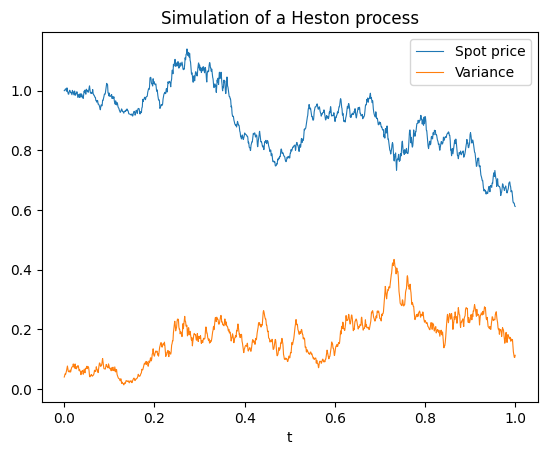

In [3]:
plt.plot(sol.ts, sol.ys[:,0], linewidth=0.8, label='Spot price')
plt.plot(sol.ts, sol.ys[:,1], linewidth=0.8, label='Variance')
plt.xlabel('t')
plt.title('Simulation of a Heston process')
plt.legend();

Functions that involve [pseudo random number generation in JAX](https://jax.readthedocs.io/en/latest/jax-101/05-random-numbers.html) always require their own key, so to simulate several realizations of a stochastic process, it is best to build a function that depends on a `key` argument, and map it to as many keys as required with `jax.vmap`. Here it is wrapped in a `simulate` function to keep track of the dependence on the parameters in `args` and specify with a `SaveAt` object at which time points we want to record the stochastic process. To plot trajectories, we want it to be dense, but to price European options, we want to record only the states at the relevant maturities of the contracts.

In [4]:
t0, t1 = 0., 1.6
t_size = 200
ts = jnp.linspace(t0, t1, t_size)
saveat = SaveAt(ts=ts)

def simulate(args, saveat, dataset_size=100):    
    @jax.jit
    @jax.vmap
    def get_data(key):
        bm_key, vol_key = jr.split(key, 2)
        
        bm = VirtualBrownianTree(t0, t1, tol=1e-3, shape=(2,), key=bm_key)
        drift_term = ODETerm(drift)
        diffusion_term = ControlTerm(diffusion, bm)
        terms = MultiTerm(drift_term, diffusion_term)
        solver = Euler()
        dt0 = 0.005
        
        r, V0, k, theta, sigma, rho = args
        y0 = jnp.array([1.0, V0])
        
        sol = diffeqsolve(
            terms, solver, t0, t1, dt0, y0, saveat=saveat, args=args
        )
        return sol.ts, sol.ys
    
    seed = 123
    key = jr.PRNGKey(seed)
    data_key = jr.split(key, dataset_size)
    
    ts, ys = get_data(data_key)
    return ts, ys

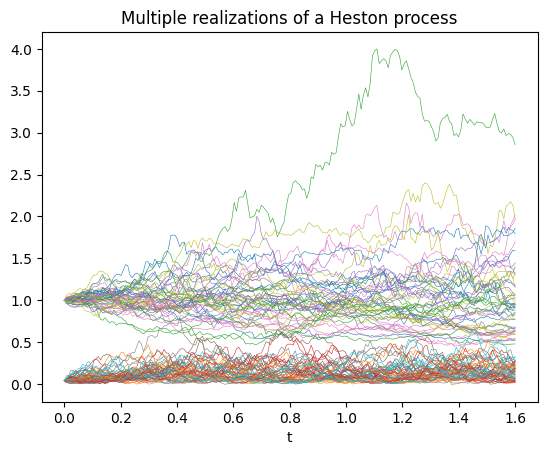

In [5]:
ts, ys = simulate(args, saveat)

for i in range(50):
    plt.plot(ts[i], ys[i], linewidth=0.4)
plt.xlabel('t')
plt.title('Multiple realizations of a Heston process')
plt.show()

## Option pricing
As an example (inspired by the [MATLAB documentation](https://www.mathworks.com/help/fininst/calibrate-option-pricing-model-using-heston-model.html)), we can calibrate this model to a European call option chain.

In [6]:
spot_price = 123.28
strikes = jnp.array([115., 120., 125., 130., 135., 140., 145])

maturity_dates = [datetime.strptime(s, '%Y;%m;%d') for s in
                  ['2015;8;21', '2015;9;18', '2015;12;18',
                   '2016;4;15', '2016;6;17', '2017;1;20']]
settle_date =datetime.strptime('2015;7;10', '%Y;%m;%d')
maturities = jnp.array([(md.date() - settle_date.date()).days/365
                        for md in maturity_dates]) #time to maturity in years

market_calls = jnp.array([
 [9.95, 10.63, 12.84, 15.1, 15.95, 20.0],
 [6.3, 7.2, 9.9, 12.3, 13.57, 17.5],
 [3.6, 4.55, 7.3, 9.7, 11.15, 15.2],
 [1.82, 2.68, 5.3, 7.7, 9.0, 13.2],
 [0.82, 1.45, 3.7, 5.85, 7.2, 11.27],
 [0.36, 0.77, 2.5, 4.48, 5.76, 9.65],
 [0.15, 0.38, 1.7, 3.44, 4.54, 8.1]])

The first step is to compute the price of these options under the Heston model. So we simulate the value of the spot price at the different maturities, we compute the option payoff for every strike price, and we return the discounted Monte Carlo mean as the option prices. Here, instead of specifying the risk-free rate, we will compute its implied value. The initial value of the variance `V0` is unknown, so we will also learn it from the option market prices. This is why these two parameters are included in the `args` parameters. On the other hand, the initial `spot_price` is an input, but we had $S_0 = 1$, so we need to multiply the simulated $S_t$ by `spot_price` to get the proper price evolution.

In [38]:
@jax.jit
def compute_call_price(spot_price, args, strikes,
                       maturities, sample_size=512):
    
    ts, ys = simulate(args,
                      SaveAt(ts=maturities),
                      dataset_size=sample_size)
    
    spot_price_at_maturity = spot_price*ys[...,0]
    r, V0, k, theta, sigma, rho = args
    discount = jnp.exp(-r*maturities)

    simulated_payoffs = jnp.maximum(
        spot_price_at_maturity[:,None] - strikes[...,None], 0)
    
    simulated_calls = discount * jnp.mean(simulated_payoffs,
                                          axis=0)
    return simulated_calls

## Calibration
For calibration, we need to penalize discrepancies between the simulated option prices and their market values. Here we choose the (unweighted) mean squared relative error. Taking the relative rather than absolute error is motivated by the fact that these option prices cover three orders of magnitude, and we want to avoid too big an influence from the options that are deep in the money. In practice, we might also introduce weights that depend on the bid-ask spreads to reflect different uncertainties in market prices. The result is a loss function that depends as required only on the `args` parameters.

In [95]:
@jax.jit
def compute_loss(args):
    simulated_calls = compute_call_price(spot_price,
                                         args,
                                         strikes,
                                         maturities)
    errors = simulated_calls - market_calls
    msre = jnp.mean((errors/market_calls)**2)
    return msre

To find the parameters that minimize this mean squared relative error and provide the best fit to the market prices, we use the [Optax](https://optax.readthedocs.io/en/latest/) library.

In [ ]:
params = jnp.array([-0.001, 0.05, .5, 0.2, 0.2, 0.])

start_learning_rate = 0.02
optimizer = optax.adam(start_learning_rate)

# Initialize parameters of the model + optimizer.
opt_state = optimizer.init(params)

history = []
mses = []

for _ in range(300):
    value, grads = jax.value_and_grad(compute_loss)(params)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    history.append(params)
    mses.append(value)

In [104]:
calls = compute_call_price(spot_price, params, strikes, maturities)

In [111]:
jnp.set_printoptions(precision=2)
print('Calibrated call prices:')
print(calls)

print('\nMarket call prices:')
print(market_calls)

Calibrated call prices:
[[ 9.98 11.38 13.47 14.87 16.19 19.94]
 [ 6.49  7.9  10.28 11.86 13.31 17.26]
 [ 3.67  4.89  7.61  9.29 10.77 14.89]
 [ 1.76  2.78  5.49  7.2   8.62 12.84]
 [ 0.76  1.56  3.89  5.49  6.86 11.05]
 [ 0.3   0.85  2.73  4.27  5.53  9.51]
 [ 0.12  0.45  1.95  3.32  4.52  8.24]]

Market call prices:
[[ 9.95 10.63 12.84 15.1  15.95 20.  ]
 [ 6.3   7.2   9.9  12.3  13.57 17.5 ]
 [ 3.6   4.55  7.3   9.7  11.15 15.2 ]
 [ 1.82  2.68  5.3   7.7   9.   13.2 ]
 [ 0.82  1.45  3.7   5.85  7.2  11.27]
 [ 0.36  0.77  2.5   4.48  5.76  9.65]
 [ 0.15  0.38  1.7   3.44  4.54  8.1 ]]


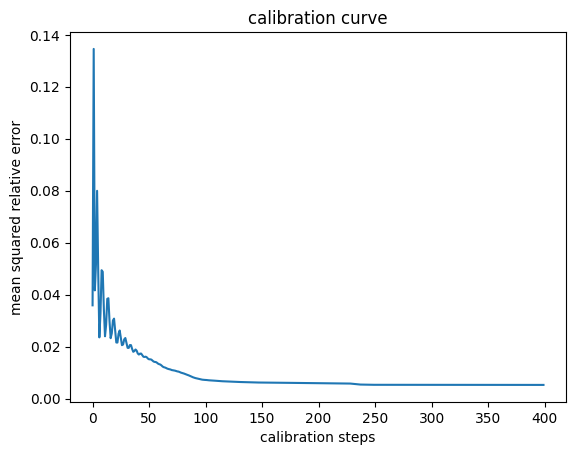

In [112]:
plt.plot(mses[:])
plt.xlabel('calibration steps')
plt.ylabel('mean squared relative error')
plt.title('calibration curve')
plt.show()

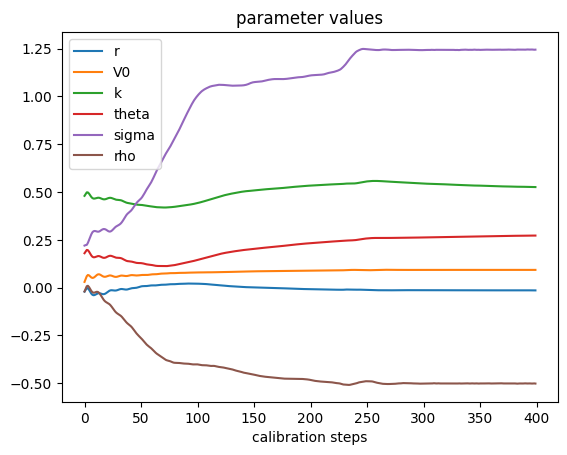

In [108]:
H = jnp.stack(history)

labels = ['r', 'V0', 'k', 'theta', 'sigma', 'rho']

for i in range(len(params)):
    plt.plot(H[:,i], label=labels[i])

plt.legend()
plt.xlabel('calibration steps')
plt.title('parameter values')
plt.show()